In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [2]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Dense, Activation, Dropout
from tensorflow.contrib.keras.python.keras.preprocessing import text, sequence
from tensorflow.contrib.keras.python.keras import utils

from collections import Counter

# This code was tested with TensorFlow v1.3
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.3.0


In [44]:
# The CSV was generated from this query: https://bigquery.cloud.google.com/savedquery/513927984416:c494494324be4a80b1fc55f613abb39c
# The data is also publicly available at this Cloud Storage URL: https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv

data = pd.read_csv("results-1000.csv")
NUM_ROWS = data.shape[0]
print("Loaded {} rows".format(NUM_ROWS))

Loaded 1000 rows


In [45]:
#Preview Data
data.head()

,post,tags
0,i have table of 8x8 i want to show images or v...,java|html|sql|oracle|jsp
1,putting the comment on a fb page i am using j...,javascript|facebook-graph-api|facebook-javascr...
2,multiple transactions in hibernate is there a...,java|hibernate
3,receiving fake path while uploading whenever ...,javascript|html|file-upload
4,replace the visual studio find results i m wa...,c#|.net|visual-studio-2010|visual-studio|visua...


In [69]:
#Generate list of N most common labels
NUM_CLASSES = 5
labels_list = []

counts = Counter('|'.join(data['tags'].tolist()).split('|'))
classes = counts.most_common(NUM_CLASSES)

for i in range(0,NUM_CLASSES):
    labels_list.append(classes[i][0])
    
print ("{} most common classes:".format(NUM_CLASSES))
classes

5 most common classes:


[('javascript', 376),
 ('java', 334),
 ('jquery', 133),
 ('c#', 100),
 ('html', 82)]

In [47]:
#utility functions to extract classes and translate between 
#human friendly (string) labels and machine friendly (array) labels

#labels_list: A list of the valid classes
#tags: A list of tags for a post
#returns an ndarray with ones for the active classes
def labels_to_array(tags,labels_list=labels_list):
    array = np.zeros(len(labels_list),dtype=np.int8)
    tags = tags.split('|') #split tags from pipe separated string into list
    for tag in tags:
        try:
            array[labels_list.index(tag)] = 1
        except ValueError: 
            None
    return array

#translate machine readable array back to human labels
def array_to_labels(array, labels_list=labels_list, threshold = 1):
    labels = []
    i=0
    for flag in array:
        if flag >= threshold: 
            labels.append(labels_list[i])
        i=i+1
    return labels

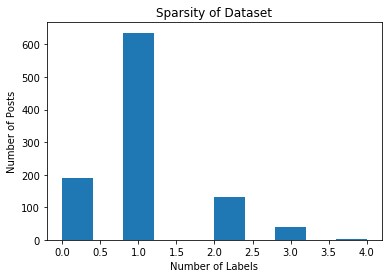

In [50]:
#Find label density
label_counts = np.zeros(NUM_ROWS)
for i in range(len(label_counts)):
    label_counts[i] = labels_to_array(data['tags'][i]).sum()
    
plt.xlabel('Number of Labels')
plt.ylabel('Number of Posts')
plt.title('Sparsity of Dataset')
plt.hist(label_counts)
plt.show()

In [53]:
#test utility functions
print(data['tags'][4])
array = labels_to_array(data['tags'][4])
print(array)
array_to_labels(array)

c#|.net|visual-studio-2010|visual-studio|visual-studio-addins
[0 0 0 1 0]


['c#']

In [54]:
# Split data into train and test
train_size = int(len(data) * .8)
test_size = len(data)-train_size
print ("Train size: %d" % train_size)
print ("Test size: %d" % test_size)

Train size: 800
Test size: 200


In [55]:
train_posts = data['post'][:train_size]
train_tags = data['tags'][:train_size]

test_posts = data['post'][train_size:]
test_tags = data['tags'][train_size:]

In [56]:
max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [57]:
tokenize.fit_on_texts(train_posts) # only fit on train
x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

In [58]:
# generate multi-label arrays
y_train = np.zeros([train_size,NUM_CLASSES])
for i in range(0,train_size):
    y_train[i] = labels_to_array(data['tags'][i])

y_test = np.zeros([test_size,NUM_CLASSES])
for i in range(0,test_size):
    y_test[i] = labels_to_array(data['tags'][i+train_size-1])
y_test[0]

array([ 1.,  0.,  0.,  1.,  0.])

In [59]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (800, 1000)
x_test shape: (200, 1000)
y_train shape: (800, 5)
y_test shape: (200, 5)


In [75]:
# This model trains very quickly and 2 epochs are already more than enough
# Training for more epochs will likely lead to overfitting on this dataset
# You can try tweaking these hyperparamaters when using this model with your own data
batch_size = 32
epochs = 20

In [76]:
# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES))
model.add(Activation('sigmoid')) #changed from softmax

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']) #changed from categorical_crossentropy

In [79]:
# model.fit trains the model
# The validation_split param tells Keras what % of our training data should be used in the validation set
# You can see the validation loss decreasing slowly when you run this
# Because val_loss is no longer decreasing we stop training to prevent overfitting
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 720 samples, validate on 80 samples
Epoch 1/20
720/720 [==============================] - 0s - loss: 0.0082 - acc: 1.0000 - val_loss: 0.3092 - val_acc: 0.9225
Epoch 2/20
720/720 [==============================] - 0s - loss: 0.0072 - acc: 0.9997 - val_loss: 0.3120 - val_acc: 0.9250
Epoch 3/20
720/720 [==============================] - 0s - loss: 0.0064 - acc: 1.0000 - val_loss: 0.3184 - val_acc: 0.9225
Epoch 4/20
720/720 [==============================] - 0s - loss: 0.0053 - acc: 1.0000 - val_loss: 0.3306 - val_acc: 0.9225
Epoch 5/20
720/720 [==============================] - 0s - loss: 0.0058 - acc: 1.0000 - val_loss: 0.3239 - val_acc: 0.9200
Epoch 6/20
720/720 [==============================] - 0s - loss: 0.0048 - acc: 1.0000 - val_loss: 0.3311 - val_acc: 0.9250
Epoch 7/20
720/720 [==============================] - 0s - loss: 0.0045 - acc: 1.0000 - val_loss: 0.3303 - val_acc: 0.9200
Epoch 8/20
720/720 [==============================] - 0s - loss: 0.0042 - acc: 1.0000 - val_lo

In [80]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

 32/200 [===>..........................] - ETA: 0sTest score: 2.11866283417
Test accuracy: 0.723000013828


In [72]:
# Here's how to generate a prediction on individual examples
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    print(prediction[0])
    print(y_test[i])
    predicted_label = array_to_labels(prediction[0],threshold=.5)
    print(test_posts.iloc[i][:200], "...")
    print('Actual label:' + '|'.join(array_to_labels(y_test[i])))
    print("Predicted label: " + '|'.join(predicted_label) + '\n')  

[  6.56057894e-01   2.53366834e-05   2.87820280e-01   1.10452510e-02
   1.33582959e-02]
[ 1.  0.  0.  1.  0.]
update single record with an array of results  a query leads to a list of results (@invoice_results - - also the name of the controller action) with two specific columns in the view (formatting remove ...
Actual label:javascript|c#
Predicted label: javascript

[  9.58396077e-01   5.00160619e-04   3.98896396e-01   1.92869891e-04
   4.05181851e-03]
[ 0.  0.  0.  0.  0.]
jquery and mouseevents  i have a question regarding mouse events in the jquery library. i have a simple javascript function as following:   <pre><code>$(function() {     var xpos;     var ypos;     $( ...
Actual label:
Predicted label: javascript

[  9.99997854e-01   1.17824595e-06   9.70770240e-01   1.46852912e-07
   6.00521713e-02]
[ 1.  0.  1.  0.  1.]
drag and drop using raphael.js has laggy performance with more than 10 draggable elements  i m making a simple html5 app  that will be wrapped to be used on andr

In [37]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=labels_list, title="Confusion matrix")
plt.show()

NameError: name 'y_test_1d' is not defined

In [ ]:
# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [35]:
#cross entropy function

def cross_entropy(y_target,y_pred):
    loss_sum = 0
    for i in range(len(y_target)):
        if y_target[i]==1: loss_sum += -np.log(y_pred[i])
        else: loss_sum += -np.log(1-y_pred[i])
    return loss_sum/len(y_target)